In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
from torch import nn
import torchvision
from torchvision import transforms
from dataset import MultiLabelDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import recall_score, precision_score, f1_score, auc

2091lines [00:00, 174724.37lines/s]


In [2]:
CONDITIONS = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
              'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
              'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
              'Support Devices']

normalize = transforms.Normalize(
    mean=[0.4684, 0.4684, 0.4684], 
    std=[0.3021, 0.3021, 0.3021]
)

generic_transform = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    normalize
])

torch.Size([1, 10, 3, 224, 224])


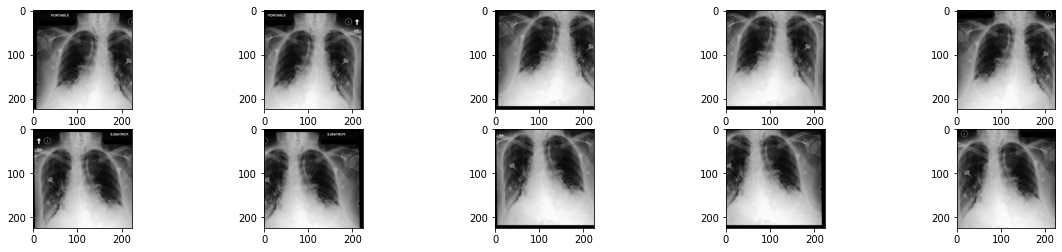

In [3]:
# Find mean and std for normalization
def find_mean_std_image():
    train_loader = DataLoader(
        MultiLabelDataset('train'),
        batch_size=64,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    )
    
    tensors = []
    for i, (imgs, labels) in enumerate(tqdm(train_loader)):
        tensors.append(imgs)
        if i > len(train_loader) // 2: # Sample just first half
            break

    print(len(tensors))
    mean = torch.stack(tensors).mean(axis=[0, 1, 2, 3])
    std = torch.stack(tensors).std(axis=[0, 1, 2, 3])
    return mean, std

def to_tensors(crops):
    return torch.stack([transforms.ToTensor()(crop) for crop in crops])

def normalize_lambda(crops):
    return torch.stack([normalize(crop) for crop in crops])

def plot_sample_images():
    test_dataset = MultiLabelDataset(
        'test',
        transform=transforms.Compose([
            transforms.Resize(256),
            transforms.TenCrop(224),
            transforms.Lambda(to_tensors),
            # transforms.Lambda(normalize_lambda)
    ]))

    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
    inp, target = next(iter(test_loader))
    print(inp.shape)
    
    plt.figure(figsize=(20, 4))
    for i in range(10):
        image = inp[0][i].permute(1, 2, 0)
        image = image.numpy()
        plt.subplot(2, 5, i+1)
        plt.imshow(image)
    plt.show()

# find_mean_std_image()
plot_sample_images()


In [4]:
class Chexnet(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, input_size=(256, 256), pretrained=True):
        super(Chexnet, self).__init__()

        encoded_image_size = input_size[0] // 32
        self.linear_input_size = 1024 * encoded_image_size ** 2
        
        # Load densenet pretrained weight into this
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        
        # Original chexnet classifier
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 14),
            nn.Sigmoid()
        )

        # Pretrained weights?
        if pretrained:
            print(f"loading pretrained weights..")
            chexnet_checkpoint_path = 'weights/chexnet.pth.tar'
            checkpoint = torch.load(chexnet_checkpoint_path)
            self.load_state_dict(checkpoint['state_dict'], strict=False)

        # Create the true densenet we're going to use
        modules = list(self.densenet121.children())[:-1]
        self.true_densenet = nn.Sequential(*modules)

        # New classifier head
        self.fc = nn.Linear(self.linear_input_size, 13)

        self = self.cuda()

    def forward(self, x):
        encoded_images = self.true_densenet(x)
        flattened = encoded_images.reshape(-1, self.linear_input_size)
        probs = torch.sigmoid(self.fc(flattened))
        return encoded_images, probs

100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


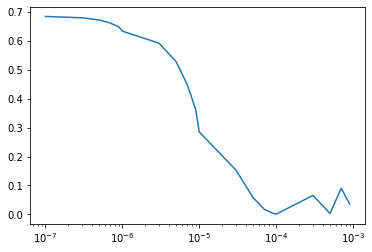

best_lr=0.0001


In [7]:
def lr_finder(encoder, imgs, labels, sweep_range):
    losses = []
    for lr in tqdm(sweep_range):
        # Init
        encoder = encoder.cuda()

        loss_fn = nn.BCELoss()
        optimizer = torch.optim.Adam(encoder.parameters(), lr)

        # Train 1 minibatch
        _, probs = encoder(imgs)
        loss = loss_fn(probs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # After
        _, probs = encoder(imgs)
        loss_after = loss_fn(probs, labels)
        losses.append(loss_after.detach().item())

        # t = torch.cuda.get_device_properties(0).total_memory
        # r = torch.cuda.memory_reserved(0)
        # a = torch.cuda.memory_allocated(0)
        # f = r-a  # free inside reserved
        # print(f"total: {t}\treserved: {r}\tallocated: {a}\tfree: {f}")

    
    return losses

def find_lr(encoder_cls, attempts=1):
    train_loader = DataLoader(
            MultiLabelDataset('train', transform=generic_transform),
            batch_size=16,
            shuffle=False,
            num_workers=0,
            pin_memory=True,
        )
    imgs, labels = next(iter(train_loader))
    sweep_range = np.hstack([[*range(1, 10, 2)][::-1] / 10 ** e for e in np.arange(4, 8, 1)])[::-1]

    for i in range(attempts):
        losses = lr_finder(encoder_cls, imgs.cuda(), labels.cuda(), sweep_range)
        plt.xscale('log')
        plt.plot(sweep_range, losses)
        plt.show()

    idx = np.argmin(losses)
    best_lr = sweep_range[idx]
    return best_lr

best_lr = find_lr(Chexnet(pretrained=False), attempts=1)
print(f"best_lr={best_lr}")

In [9]:
def save_checkpoint(epoch, encoder, optimizer, scheduler, train_loss, val_loss):
    cur_time = str(datetime.now())
    state = {'epoch': epoch,
             'encoder': encoder,
             'optimizer': optimizer,
             'scheduler': scheduler,
             'time_saved': cur_time,
             'train_loss': train_loss,
             'val_loss': val_loss,
    }

    cur_time = cur_time.replace(' ', '_').replace(':', '-')
    filename = 'weights/pretrained_encoder/pretrained_enc_' + cur_time + '.pth.tar'
    torch.save(state, filename)

def pretrain_encoder(encoder, train_loader, loss_fn, optimizer, epoch):
    encoder.train()
    losses = []

    for i, (imgs, labels) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()

        imgs = imgs.cuda()
        labels = labels.cuda()

        _, probs = encoder(imgs)
        loss = loss_fn(probs, labels)
        losses.append(loss)
        loss.backward()
        if ((i + 1) % 4) == 0 or (i + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()

    return torch.stack(losses).mean()

def validate_pretrained_encoder(encoder, val_loader, loss_fn):
    encoder.eval()
    losses = []
    
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(tqdm(val_loader)):
            imgs = imgs.cuda()
            labels = labels.cuda()

            _, probs = encoder(imgs)
            loss = loss_fn(probs, labels)
            losses.append(loss)
            

    return torch.stack(losses).mean()

In [22]:
checkpoint_path = 'weights/pretrained_encoder/pretrained_enc_2022-02-26_16-38-13.950274.pth.tar' # Pretrained Chexnet epoch 9
# checkpoint_path = 'weights/pretrained_encoder/pretrained_enc_2022-02-27_10-48-21.387666.pth.tar' # Pretrained Densenet epoch 2
# checkpoint_path = None
epochs = 10
if checkpoint_path != None:
    checkpoint = torch.load(checkpoint_path)
    start_epoch = checkpoint['epoch'] + 1
    encoder = checkpoint['encoder']
    optimizer = checkpoint['optimizer']
    scheduler = checkpoint['scheduler']
    print(f"start from epoch: {start_epoch} val_loss: {checkpoint['val_loss']}")
else:
    start_epoch = 0
    encoder = Chexnet(pretrained=False).cuda()
    optimizer = torch.optim.Adam(encoder.parameters(), lr=7e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        'min', 
        factor=0.2, 
        patience=2, 
        min_lr=1e-6
    )

loss_fn = nn.BCELoss().cuda()

start from epoch: 9 val_loss: 0.437190443277359


In [11]:
train_loader = DataLoader(
    MultiLabelDataset('train', transform=generic_transform),
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

val_loader = DataLoader(
    MultiLabelDataset('val', transform=generic_transform),
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

In [12]:
lrs = []
train_plot = []
val_plot = []

start training from epoch 0
Training epoch 1 with lr = 7e-05...


100%|██████████| 1283/1283 [07:38<00:00,  2.80it/s]


Validating...


100%|██████████| 171/171 [00:18<00:00,  9.16it/s]


train_loss: 0.4379611015319824, val_loss: 0.4074287712574005
Training epoch 2 with lr = 7e-05...


100%|██████████| 1283/1283 [07:08<00:00,  3.00it/s]


Validating...


100%|██████████| 171/171 [00:18<00:00,  9.07it/s]


train_loss: 0.39484259486198425, val_loss: 0.40862220525741577
Training epoch 3 with lr = 7e-05...


100%|██████████| 1283/1283 [06:59<00:00,  3.05it/s]


Validating...


100%|██████████| 171/171 [00:18<00:00,  9.03it/s]


train_loss: 0.3932010233402252, val_loss: 0.4303218126296997
Training epoch 4 with lr = 7e-05...


100%|██████████| 1283/1283 [07:21<00:00,  2.91it/s]


Validating...


100%|██████████| 171/171 [00:20<00:00,  8.50it/s]


train_loss: 0.396599680185318, val_loss: 0.5150259733200073
Training epoch 5 with lr = 1.4e-05...


100%|██████████| 1283/1283 [07:21<00:00,  2.91it/s]


Validating...


100%|██████████| 171/171 [00:18<00:00,  9.32it/s]


train_loss: 0.3663404881954193, val_loss: 0.4441235363483429
Training epoch 6 with lr = 1.4e-05...


100%|██████████| 1283/1283 [07:27<00:00,  2.87it/s]


Validating...


100%|██████████| 171/171 [00:21<00:00,  8.05it/s]


train_loss: 0.3549495041370392, val_loss: 0.43788135051727295
Training epoch 7 with lr = 1.4e-05...


100%|██████████| 1283/1283 [07:20<00:00,  2.91it/s]


Validating...


100%|██████████| 171/171 [00:19<00:00,  8.65it/s]


train_loss: 0.3558950424194336, val_loss: 0.4572436213493347
Training epoch 8 with lr = 2.8000000000000003e-06...


100%|██████████| 1283/1283 [07:41<00:00,  2.78it/s]


Validating...


100%|██████████| 171/171 [00:23<00:00,  7.43it/s]


train_loss: 0.35412272810935974, val_loss: 0.45492714643478394
Training epoch 9 with lr = 2.8000000000000003e-06...


100%|██████████| 1283/1283 [07:25<00:00,  2.88it/s]


Validating...


100%|██████████| 171/171 [00:23<00:00,  7.13it/s]


train_loss: 0.35524967312812805, val_loss: 0.45908695459365845
Training epoch 10 with lr = 2.8000000000000003e-06...


100%|██████████| 1283/1283 [07:30<00:00,  2.85it/s]


Validating...


100%|██████████| 171/171 [00:24<00:00,  7.07it/s]


train_loss: 0.3569543659687042, val_loss: 0.4574025571346283


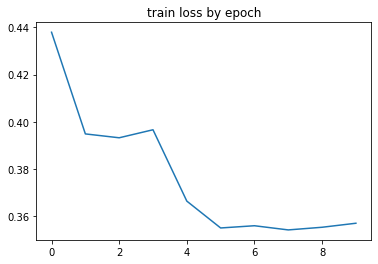

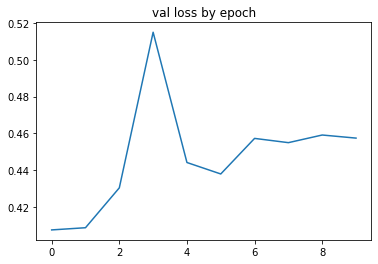

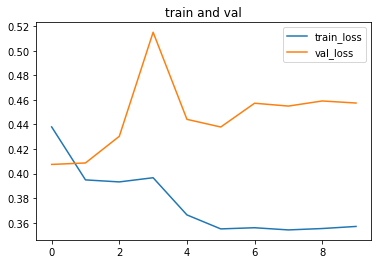

In [13]:
def train():
    print(f"start training from epoch {start_epoch}")
    for epoch in range(start_epoch, start_epoch + epochs):
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)
        print(f"Training epoch {epoch+1} with lr = {current_lr}...")
        train_loss = pretrain_encoder(encoder, train_loader, loss_fn, optimizer, epoch)
        print(f"Validating...")
        val_loss = validate_pretrained_encoder(encoder, val_loader, loss_fn)
        print(f"train_loss: {train_loss}, val_loss: {val_loss}")
        train_plot.append(train_loss)
        val_plot.append(val_loss)
        scheduler.step(val_loss)
        save_checkpoint(epoch, encoder, optimizer, scheduler, train_loss, val_loss)

    plt.title('train loss by epoch')
    plt.plot(train_plot)
    plt.show()
    plt.title('val loss by epoch')
    plt.plot(val_plot)
    plt.show()
    plt.title('train and val')
    plt.plot(train_plot, label='train_loss')
    plt.plot(val_plot, label='val_loss')
    plt.legend()
    plt.show()

train()
# https://pastebin.com/a50FBU0F

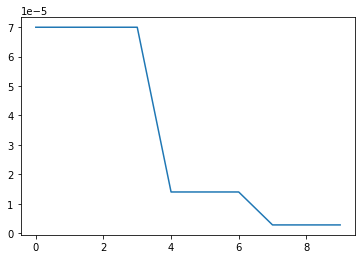

In [14]:
plt.plot(lrs)
plt.show()

In [17]:
def predict_val(encoder, val_loader, loss_fn):
    encoder.eval()
    losses = []
    results = []
    true = []
    
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(tqdm(val_loader)):
            imgs = imgs.cuda()
            labels = labels.cuda()

            _, probs = encoder(imgs)
            loss = loss_fn(probs, labels)
            losses.append(loss)
            true.append(labels)
            results.append(probs)
            
    val_loss = torch.stack(losses).mean()
    print(f"val_loss: {val_loss}")

    val_preds = torch.stack(results).reshape(-1, 13)
    ground_truth = torch.stack(true).reshape(-1, 13)
    return val_preds, ground_truth

def get_tpr_fpr(pred, true, threshold):
    p = pred.clone()
    t = true.clone()
    p = (p > threshold).int().cpu().numpy()
    t = t.int().cpu().numpy()

    tp = np.count_nonzero(np.logical_and(p == 1, t == 1), axis=0)
    tn = np.count_nonzero(np.logical_and(p == 0, t == 0), axis=0)
    fp = np.count_nonzero(np.logical_and(p == 1, t == 0), axis=0)
    fn = np.count_nonzero(np.logical_and(p == 0, t == 1), axis=0)
    
    tpr = np.zeros(13)
    fpr = np.zeros(13)

    for i in range(13):
        if tp[i] + fn[i] == 0:
            tpr[i] = 0.0
        else:
            tpr[i] = tp[i] / (tp[i] + fn[i])
        
        if tn[i] + fp[i] == 0:
            fpr[i] = 0.0
        else:
            fpr[i] = fp[i] / (tn[i] + fp[i])

    return tpr, fpr

def roc_coords(pred, true):
    threshold_sweep = np.arange(0.000, 1.001, 0.001)
    tprs = []
    fprs = []
    min_dist = np.full(shape=(13,), fill_value=np.inf)
    best_threshold = np.zeros(13)
    best_tpr = np.zeros(13)
    best_fpr = np.zeros(13)
    for t in threshold_sweep:
        tpr, fpr = get_tpr_fpr(pred, true, t)
        tprs.append(tpr)
        fprs.append(fpr)
        
        # Dist from (0, 1)
        dist = np.sqrt((fpr-0)**2 + (tpr-1)**2)
        for i in range(13):
            if dist[i] < min_dist[i]:
                min_dist[i] = dist[i]
                best_tpr[i] = tpr[i]
                best_fpr[i] = fpr[i]
                best_threshold[i] = t
    
    tprs = np.vstack(tprs).T # (13, sample_size)
    fprs = np.vstack(fprs).T # (13, sample_size)

    return tprs, fprs, best_tpr, best_fpr, best_threshold

def plot_roc(val_preds, ground_truth):
    tprs, fprs, best_tpr, best_fpr, best_threshold = roc_coords(val_preds, ground_truth)
    aucs = np.zeros(13)
    plt.figure(figsize=(28, 8))
    
    for i in range(13):
        x = np.arange(0, 1, 1/len(tprs[i]))
        y = np.arange(1, 0, -1/len(tprs[i]))
        area = auc(fprs[i], tprs[i])
        aucs[i] = area
        title = \
            f'{CONDITIONS[i]}\n' + \
            f'EER={best_tpr[i]:4f}\n' + \
            f'Best threshold = {best_threshold[i]:4f}\n' + \
            f'AUROC={area:.4f}'
        
        plt.subplot(2, 7, i+1)
        plt.title(title)
        plt.plot(x, y, 'r--')
        plt.plot(fprs[i], tprs[i])
        plt.plot(best_fpr[i], best_tpr[i], 'go')
    plt.tight_layout()
    plt.show()

    df = pd.DataFrame.from_dict({
        'Diagnosis': CONDITIONS,
        'EER': best_tpr,
        'Best Threshold': best_threshold,
        'AUROC': aucs,
    }).set_index('Diagnosis')
    return df

In [28]:
val_preds, ground_truth = predict_val(encoder, val_loader, loss_fn)

100%|██████████| 171/171 [00:26<00:00,  6.55it/s]

val_loss: 0.4331200122833252


In [24]:
print(get_tpr_fpr(val_preds, ground_truth, 0.5))

(array([0.78313253, 0.64857143, 0.81355932, 0.18045113, 0.58846154,
       0.61254613, 0.37209302, 0.63537906, 0.03921569, 0.6       ,
       0.30188679, 0.43880597, 0.63525836]), array([0.14165792, 0.1021611 , 0.12251309, 0.01862348, 0.04783394,
       0.08113036, 0.05030356, 0.0944088 , 0.0015186 , 0.06767587,
       0.08477509, 0.14230397, 0.06737247]))


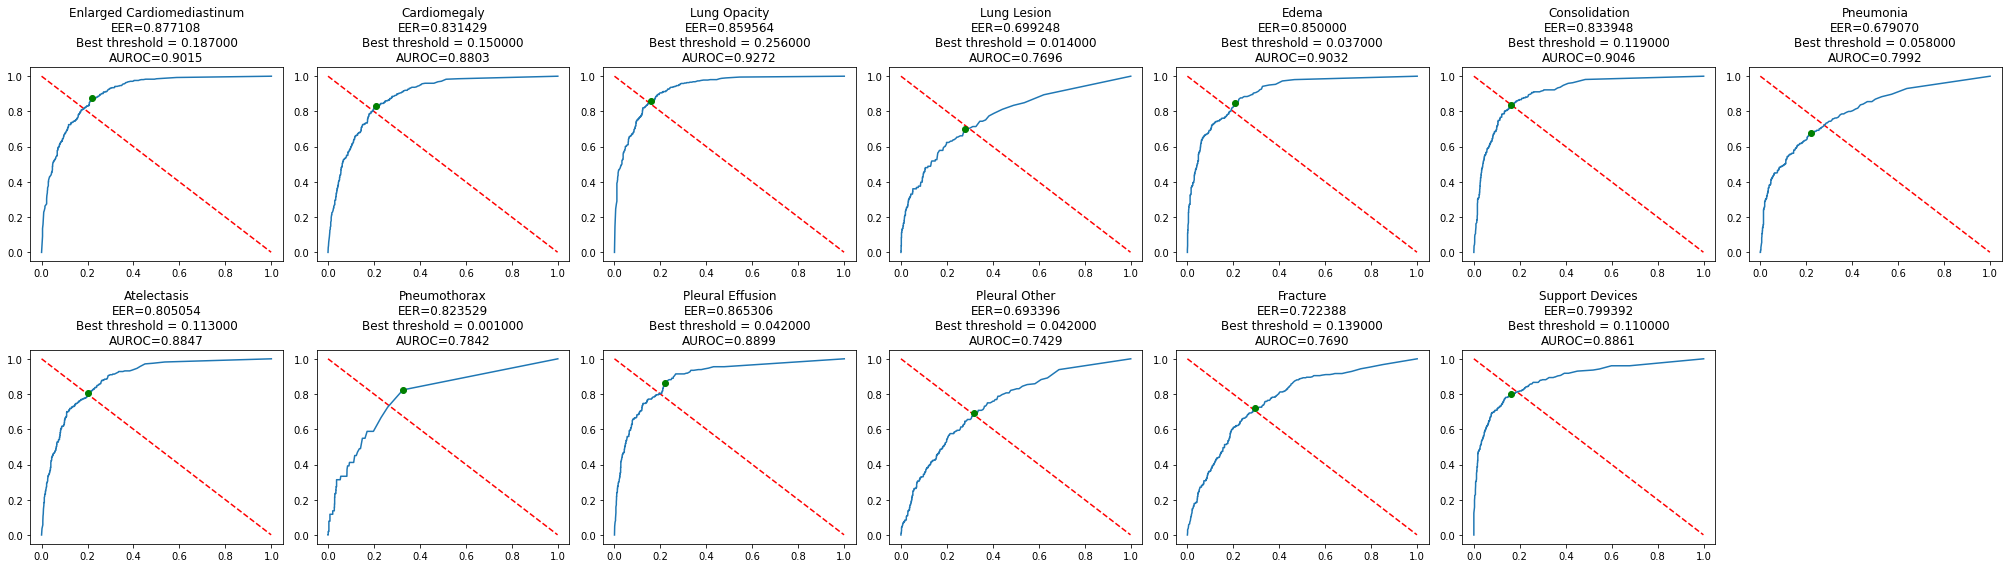

In [29]:
results_df = plot_roc(val_preds, ground_truth)

### ROC Stuff
### Pretrained Chexnet
```
                                 EER  Best Threshold     AUROC  Chexnet
Diagnosis                                                              
Enlarged Cardiomediastinum  0.843373           0.227  0.903488      NaN
Cardiomegaly                0.834286           0.115  0.881514   0.9248
Lung Opacity                0.869249           0.282  0.925403      NaN
Lung Lesion                 0.699248           0.019  0.773435      NaN
Edema                       0.807692           0.070  0.900809   0.8878
Consolidation               0.848708           0.073  0.898465   0.7901
Pneumonia                   0.688372           0.047  0.784017   0.7680
Atelectasis                 0.790614           0.167  0.888520   0.8094
Pneumothorax                0.764706           0.001  0.755832   0.8887
Pleural Effusion            0.885714           0.032  0.889074   0.8638
Pleural Other               0.707547           0.024  0.742141      NaN
Fracture                    0.668657           0.139  0.756783      NaN
Support Devices             0.778116           0.117  0.885187      NaN
```

In [30]:
# Chexnet results from https://arxiv.org/pdf/1711.05225.pdf
results_df['Chexnet'] = [np.nan, 0.9248, np.nan, np.nan, 0.8878, 0.7901, 0.7680, 0.8094, 0.8887, 0.8638, np.nan, np.nan, np.nan]
results_df

,EER,Best Threshold,AUROC,Chexnet
Diagnosis,,,,
Enlarged Cardiomediastinum,0.877108,0.187,0.901474,NaN
Cardiomegaly,0.831429,0.150,0.880314,0.9248
Lung Opacity,0.859564,0.256,0.927182,NaN
Lung Lesion,0.699248,0.014,0.769608,NaN
Edema,0.850000,0.037,0.903180,0.8878
Consolidation,0.833948,0.119,0.904646,0.7901
Pneumonia,0.679070,0.058,0.799215,0.7680
Atelectasis,0.805054,0.113,0.884735,0.8094
Pneumothorax,0.823529,0.001,0.784202,0.8887


## Evaluation Matrix

### Pretrained Chexnet
```
Metrics                       Recall  Precision        F1
Enlarged Cardiomediastinum  0.954217   0.555400  0.702128
Cardiomegaly                0.928571   0.498466  0.648703
Lung Opacity                0.953995   0.579412  0.720952
Lung Lesion                 0.571429   0.249180  0.347032
Edema                       0.884615   0.490405  0.631001
Consolidation               0.896679   0.471845  0.618321
Pneumonia                   0.711628   0.324153  0.445415
Atelectasis                 0.888087   0.447273  0.594921
Pneumothorax                0.352941   0.159292  0.219512
Pleural Effusion            0.881633   0.447205  0.593407
Pleural Other               0.702830   0.280603  0.401077
Fracture                    0.817910   0.357236  0.497278
Support Devices             0.854103   0.503584  0.633596
Macro                       0.799895   0.412619  0.542565
Micro                       0.855961   0.440805  0.581927
```

In [43]:
def evaluation_matrix(pred, true):
    t = true.copy()
    p = pred.copy()

    recall = ['Recall']
    for col in t.columns:
        recall.append(recall_score(t[col], p[col]))

    recall.append(recall_score(t, p, average='macro'))
    recall.append(recall_score(t, p, average='micro'))

    precision = ['Precision']
    for col in t.columns:
        precision.append(precision_score(t[col], p[col]))

    precision.append(precision_score(t, p, average='macro'))
    precision.append(precision_score(t, p, average='micro'))

    f1 = ['F1']
    for col in t.columns:
        f1.append(f1_score(t[col], p[col]))

    f1.append(f1_score(t, p, average='macro'))
    f1.append(f1_score(t, p, average='micro'))

    res = pd.DataFrame([
        recall,
        precision,
        f1
    ], columns=['Metrics'] + list(t.columns) + ['Macro', 'Micro'])
    res = res.set_index(['Metrics'])

    return res.T

best_threshold = 0.034
pred_df = pd.DataFrame((val_preds > best_threshold).int().cpu().numpy(), columns=CONDITIONS)
true_df = pd.DataFrame(ground_truth.int().cpu().numpy(), columns=CONDITIONS)
evaluation_matrix(pred_df, true_df)

Metrics,Recall,Precision,F1
Enlarged Cardiomediastinum,0.939759,0.556348,0.698925
Cardiomegaly,0.902857,0.495298,0.639676
Lung Opacity,0.946731,0.579259,0.718750
Lung Lesion,0.586466,0.273684,0.373206
Edema,0.846154,0.497738,0.626781
Consolidation,0.878229,0.481781,0.622222
Pneumonia,0.702326,0.322650,0.442167
Atelectasis,0.902527,0.453721,0.603865
Pneumothorax,0.274510,0.134615,0.180645
Pleural Effusion,0.869388,0.453191,0.595804
